In [3]:
# BLOQUE 0: Instalación de Librerías
# ---
# Instala la librería 'category_encoders' si no está presente.
# Esta librería es necesaria para la codificación de variables categóricas,
# específicamente para el Target Encoding que se usará más adelante.
# El comando '!' ejecuta un comando de shell desde el notebook.
# Solo es necesario ejecutar esto una vez por sesión de Colab/Jupyter.

!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.0 MB/s eta 0:00:00


In [4]:
# BLOQUE 1: Importaciones y Configuración Inicial
# ---
# Importa las librerías necesarias y configura el entorno.

# Google Colab: Montar Google Drive para acceder a los archivos
from google.colab import drive
drive.mount('/content/drive')

# Librerías estándar para manipulación de datos y cálculo numérico
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Para visualización (aunque no se usa activamente en este script final)
import os # Para interactuar con el sistema operativo (crear carpetas)

# Librerías geoespaciales
from geopy.distance import geodesic # Para calcular distancias entre coordenadas

# Librerías de Scikit-learn para preprocesamiento, clustering, PCA y modelado
from sklearn.cluster import KMeans # Para clustering geográfico
from sklearn.decomposition import PCA # Para reducción de dimensionalidad geográfica
from sklearn.preprocessing import StandardScaler, SplineTransformer, PolynomialFeatures # Para escalado, splines y características polinómicas
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Para dividir datos y buscar hiperparámetros
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Para evaluar el modelo

# Librería para Gradient Boosting
import xgboost as xgb # Modelo principal que se entrenará

# Librería para codificación de categóricas
import category_encoders as ce # Específicamente para TargetEncoder

# Librería para guardar/cargar objetos Python (modelos, scalers, etc.)
import joblib

# Configuración de la semilla aleatoria para reproducibilidad
# Cualquier operación estocástica (train_test_split, KMeans, PCA, XGBoost, RandomizedSearch)
# usará esta semilla para producir los mismos resultados en diferentes ejecuciones.
RNG = 42

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# BLOQUE 2: Carga de Datos y Selección Inicial de Columnas
# ---
# Carga el dataset limpio desde Google Drive y selecciona las columnas
# que se consideran relevantes para el modelo inicial.

# Ruta al archivo CSV en Google Drive
# Asegúrate de que esta ruta sea correcta en tu Drive.
file_path = '/content/drive/MyDrive/Dataset Idealista/pisosBarcelona-10-05-2025-clean.csv' # cite: 1

# Carga el archivo CSV en un DataFrame de Pandas
# Se especifica 'encoding='latin1'' por si hay caracteres especiales no estándar.
df = pd.read_csv(file_path, encoding='latin1') # cite: 1

# Lista de columnas consideradas relevantes para el modelo
# Se seleccionan características sobre el precio, tamaño, distribución, ubicación,
# extras (ascensor, parking) y metadatos (fotos, estado).
relevant_cols = [
    'price','size','rooms','bathrooms','floor','hasLift','exterior', # cite: 1
    'propertyType','status','numPhotos','latitude','longitude', # cite: 1
    'hasParking','isParkingIncludedInPrice' # cite: 1
]

# Crea una copia del DataFrame original conteniendo solo las columnas relevantes
# Es buena práctica trabajar sobre una copia para no modificar el DataFrame original.
df_model = df[relevant_cols].copy() # cite: 1

# Imprime las dimensiones del DataFrame cargado para verificación
print(f"Cargados {df_model.shape[0]} registros y {df_model.shape[1]} columnas") # cite: 1

Cargados 11989 registros y 14 columnas


In [6]:
# BLOQUE 3: Limpieza, Formateo e Imputación de Nulos
# ---
# Prepara las columnas seleccionadas: convierte tipos, maneja valores especiales,
# combina características e imputa valores faltantes (NaN).

# Crear una copia explícita para evitar SettingWithCopyWarning
df_model = df_model.copy()

# 1. Procesamiento de la columna 'floor'
#    - Mapeo: Convierte valores de texto ('bj', 'en', 'ss') a numéricos (0, 0.5, -1). # cite: 1
#    - Conversión: Intenta convertir toda la columna a numérica. Los errores (ej. 'ático') se fuerzan a NaN.
#    - Imputación: Rellena los NaN resultantes (incluyendo los originales y los forzados)
#                 con la mediana de los valores numéricos *después* del mapeo inicial.
floor_map = {'bj': 0.0, 'en': 0.5, 'ss': -1.0} # cite: 1
# Primero, calcula la mediana de los valores mapeados (ignorando NaNs)
median_floor_mapped = df_model['floor'].replace(floor_map).apply(pd.to_numeric, errors='coerce').median()
# Luego, aplica el mapeo, convierte a numérico y rellena NaN con la mediana calculada
df_model['floor'] = pd.to_numeric(
    df_model['floor'].replace(floor_map),
    errors='coerce'
).fillna(median_floor_mapped) # cite: 1

# 2. Procesamiento de la columna 'exterior'
#    - Mapeo: Convierte True a 1, False a 0, y 'Unknown' a NaN. # cite: 1
#    - Conversión: Intenta convertir a numérico (forzando errores a NaN, aunque no debería haberlos tras el mapeo).
#    - Imputación: Rellena los NaN con la moda (valor más frecuente: 0 o 1) de la columna. # cite: 1
#    - Tipo final: Convierte la columna a tipo entero.
mode_exterior = pd.to_numeric(df_model['exterior'].replace({'Unknown':np.nan, True:1, False:0}), errors='coerce').mode()[0]
df_model['exterior'] = pd.to_numeric(
    df_model['exterior'].replace({'Unknown':np.nan, True:1, False:0}),
    errors='coerce'
).fillna(mode_exterior).astype(int) # cite: 1

# 3. Procesamiento de la columna 'hasLift'
#    - Imputación: Rellena los NaN directamente con la moda (0 o 1). # cite: 1
#    - Tipo final: Convierte la columna a tipo entero.
mode_hasLift = df_model['hasLift'].mode()[0]
df_model['hasLift'] = df_model['hasLift'].fillna(mode_hasLift).astype(int) # cite: 1

# 4. Procesamiento de la columna 'status'
#    - Imputación: Rellena los NaN con la cadena 'Unknown'. # cite: 1
df_model['status'] = df_model['status'].fillna('Unknown')

# 5. Combinación de características de Parking
#    - Crea una nueva columna 'parking_status' con tres categorías:
#      'Included': Tiene parking y está incluido en el precio.
#      'Optional': Tiene parking pero NO está incluido (se paga aparte).
#      'None': No tiene parking.
#    - Usa np.select para aplicar esta lógica condicional.
#    - Elimina las columnas originales 'hasParking' e 'isParkingIncludedInPrice'.
conds = [
    (df_model['hasParking']==1)&(df_model['isParkingIncludedInPrice']==1), # cite: 1
    (df_model['hasParking']==1)&(df_model['isParkingIncludedInPrice']==0), # cite: 1
    (df_model['hasParking']==0) # cite: 1
]
choices = ['Included','Optional','None'] # cite: 1
df_model['parking_status'] = np.select(conds, choices, default='Unknown') # cite: 1
df_model.drop(['hasParking','isParkingIncludedInPrice'], axis=1, inplace=True) # cite: 1

# 6. Creación de Flags para Nulos en Numéricos Clave
#    - Antes de imputar Nulos en columnas numéricas importantes, crea columnas "flag" (indicadoras).
#    - Estas flags (0 o 1) indican si el valor original en esa fila era nulo o no.
#    - Esto permite al modelo saber qué valores fueron imputados, lo cual puede ser informativo.
numeric_cols_to_impute = ['size','rooms','bathrooms','latitude','longitude']
for c in numeric_cols_to_impute:
    df_model[f'isna_{c}'] = df_model[c].isna().astype(int) # cite: 1

# 7. Imputación de Nulos en Numéricos Clave
#    - Rellena los valores NaN restantes en estas columnas con sus respectivas medianas. # cite: 1
#    - Guardamos las medianas calculadas para usarlas en la predicción de nuevos datos.
imputation_values = {} # Diccionario para guardar valores de imputación
for c in numeric_cols_to_impute:
    median_val = df_model[c].median() # cite: 1
    df_model[c] = df_model[c].fillna(median_val)
    imputation_values[f'median_{c}'] = median_val # Guardar mediana

# Guardar también la mediana/moda de otras columnas imputadas antes
imputation_values['median_floor'] = median_floor_mapped
imputation_values['mode_exterior'] = mode_exterior
imputation_values['mode_hasLift'] = mode_hasLift

# 8. Verificación Final de Nulos
#    - Comprueba si quedan valores nulos en el DataFrame después de toda la limpieza.
print("\nValores nulos restantes tras limpieza e imputación:")
print(df_model.isna().sum())


Valores nulos restantes tras limpieza e imputación:
price             0
size              0
rooms             0
bathrooms         0
floor             0
hasLift           0
exterior          0
propertyType      0
status            0
numPhotos         0
latitude          0
longitude         0
parking_status    0
isna_size         0
isna_rooms        0
isna_bathrooms    0
isna_latitude     0
isna_longitude    0
dtype: int64


<ipython-input-6-90f4b6613808>:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mode_exterior = pd.to_numeric(df_model['exterior'].replace({'Unknown':np.nan, True:1, False:0}), errors='coerce').mode()[0]
<ipython-input-6-90f4b6613808>:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model['exterior'].replace({'Unknown':np.nan, True:1, False:0}),
<ipython-input-6-90f4b6613808>:38: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objec

In [7]:
# BLOQUE 4: Ingeniería de Características Espaciales
# ---
# Crea nuevas características basadas en la ubicación geográfica (latitud, longitud).

# 1. Cálculo de Distancias a Puntos de Interés (POIs)
#    - Define un diccionario con nombres y coordenadas (lat, lon) de POIs relevantes en Barcelona.
pois = {
  'Catalunya':(41.3874,2.1700), # cite: 1
  'Barceloneta':(41.3790,2.1885), # cite: 1
  'Sants':(41.3793,2.1400), # cite: 1
  'CampNou':(41.3809,2.1228), # cite: 1
  'ParcGuell':(41.4145,2.1527) # cite: 1
}
#    - Obtiene las coordenadas de cada piso en el DataFrame.
coords = list(zip(df_model['latitude'],df_model['longitude'])) # cite: 1
#    - Para cada POI, calcula la distancia geodésica (en km) desde cada piso al POI.
#    - Añade cada conjunto de distancias como una nueva columna al DataFrame.
for name, loc in pois.items():
    df_model[f'DistKm_{name}'] = [
        geodesic(loc, xy).km for xy in coords
    ] # cite: 1

# 2. Clustering Geográfico y PCA
#    - Escala las coordenadas (latitud, longitud) usando StandardScaler.
#      Esto es importante para que KMeans y PCA no se vean sesgados por la escala de las variables.
#      Guardamos el scaler ajustado ('scaler_geo') para usarlo en predicciones.
scaler_geo = StandardScaler() # cite: 1 (modified)
geo = scaler_geo.fit_transform(df_model[['latitude','longitude']]) # cite: 1 (modified)

#    - Aplica KMeans a las coordenadas escaladas para agrupar los pisos en clusters geográficos.
#      'n_clusters=8' define el número de zonas geográficas.
#      'random_state=RNG' asegura reproducibilidad.
#      'n_init='auto'' es la configuración recomendada para evitar warnings.
#      Guardamos el modelo KMeans ajustado ('kmeans') para usarlo en predicciones.
kmeans = KMeans(n_clusters=8, random_state=RNG, n_init='auto').fit(geo) # cite: 1
#      Añade la etiqueta del cluster asignado a cada piso como una nueva columna.
df_model['geo_cluster'] = kmeans.labels_ # cite: 1

#    - Aplica PCA (Análisis de Componentes Principales) a las coordenadas escaladas.
#      Reduce las dos dimensiones (lat, lon) a una sola componente principal ('n_components=1').
#      Esta componente captura la mayor varianza direccional de los datos geográficos.
#      Guardamos el objeto PCA ajustado ('pca_geo') para usarlo en predicciones.
pca_geo = PCA(n_components=1, random_state=RNG) # cite: 1 (modified)
pca1 = pca_geo.fit_transform(geo) # cite: 1 (modified)
#      Añade esta componente principal como una nueva columna.
df_model['geo_pca1'] = pca1.flatten() # cite: 1

# 3. Precio Medio Logarítmico por Cluster Geográfico
#    - Calcula el logaritmo natural del precio + 1 (log1p) para reducir el sesgo de precios altos
#      y estabilizar la varianza. Esta será la variable objetivo ('target') para el modelo.
df_model['price_log'] = np.log1p(df_model['price']) # cite: 1
#    - Calcula el precio medio logarítmico para cada cluster geográfico ('geo_cluster').
#      'transform('mean')' asigna la media del cluster a cada piso perteneciente a ese cluster.
cluster_avg = df_model.groupby('geo_cluster')['price_log'].transform('mean') # cite: 1
#    - Añade este precio medio logarítmico del cluster como una nueva característica.
#      Esto captura la tendencia general de precios de la zona geográfica del piso.
df_model['cluster_avg_logprice'] = cluster_avg # cite: 1
#    - Guardamos el mapeo cluster -> avg_logprice para usarlo en predicciones.
cluster_avg_logprice_map = df_model.groupby('geo_cluster')['price_log'].mean() # cite: 1

print("\nNuevas columnas geoespaciales creadas:")
print(df_model[['latitude', 'longitude', 'DistKm_Catalunya', 'geo_cluster', 'geo_pca1', 'cluster_avg_logprice']].head())


Nuevas columnas geoespaciales creadas:
    latitude  longitude  DistKm_Catalunya  geo_cluster  geo_pca1  \
0  41.383123   2.130053          3.374851            2 -0.681945   
1  41.428589   2.183113          4.704104            4  0.887272   
2  41.399013   2.149954          2.115255            5 -0.115052   
3  41.422941   2.119466          5.782394            5 -0.084358   
4  41.402096   2.188198          2.231663            5  0.462985   

   cluster_avg_logprice  
0             12.523521  
1             12.234607  
2             13.002796  
3             13.002796  
4             13.002796  


In [8]:
# BLOQUE 5: Codificación de Variables Categóricas (Target Encoding)
# ---
# Convierte variables categóricas seleccionadas a numéricas usando Target Encoding.
# Target Encoding reemplaza cada categoría con la media (suavizada) de la variable
# objetivo ('price_log') para esa categoría.

# Lista de columnas categóricas a codificar con Target Encoding.
te_cols = ['propertyType','status','parking_status'] # cite: 1

# Inicializa el TargetEncoder.
# 'cols=te_cols' especifica las columnas a codificar.
# 'smoothing=10' es un parámetro de regularización que ayuda a evitar el overfitting,
# especialmente para categorías con pocas muestras. Mezcla la media de la categoría
# con la media global de la variable objetivo.
te = ce.TargetEncoder(cols=te_cols, smoothing=10) # cite: 1

# Ajusta el TargetEncoder al conjunto de datos y transforma las columnas especificadas.
# Se usa la variable objetivo 'price_log' para calcular las medias por categoría.
# Las columnas originales en 'df_model' son reemplazadas por sus versiones codificadas.
# Guardamos el encoder ajustado ('te') para usarlo en predicciones.
df_model[te_cols] = te.fit_transform(df_model[te_cols], df_model['price_log']) # cite: 1

print("\nColumnas categóricas tras Target Encoding:")
print(df_model[te_cols].head())


Columnas categóricas tras Target Encoding:
   propertyType     status  parking_status
0     12.649993  12.744006       12.603933
1     12.649993  12.744006       12.603933
2     12.649993  12.744006       12.603933
3     13.466522  12.744006       12.603933
4     12.649993  12.744006       12.603933


In [9]:
# BLOQUE 6: Creación de Características No Lineales (Splines y Polinomios)
# ---
# Genera nuevas características para capturar relaciones no lineales entre
# las variables existentes y la variable objetivo.

# 1. Características Spline
#    - Los splines permiten modelar relaciones no lineales suaves.
#    - Se aplica SplineTransformer a la columna 'size' y a las distancias a POIs.
spline_input_cols = ['size'] + [f'DistKm_{p}' for p in pois] # cite: 1 (derived)
#    - 'degree=3' usa splines cúbicos.
#    - 'n_knots=5' define el número de puntos (nudos) donde las piezas del spline se unen.
#    - 'include_bias=False' evita añadir una columna de sesgo (intercepto).
spline = SplineTransformer(degree=3, n_knots=5, include_bias=False) # cite: 1
#    - Ajusta el transformador y genera las nuevas características spline.
#    - Guardamos el transformador ajustado ('spline') para usarlo en predicciones.
spline_feats = spline.fit_transform(df_model[spline_input_cols]) # cite: 1
#    - Obtiene los nombres de las nuevas características spline generadas.
spline_names = spline.get_feature_names_out(spline_input_cols) # cite: 1
#    - Crea un DataFrame con las nuevas características spline.
df_splines = pd.DataFrame(spline_feats, columns=spline_names, index=df_model.index) # cite: 1
#    - Concatena el DataFrame original con el de las características spline.
df_model = pd.concat([df_model, df_splines], axis=1) # cite: 1

# 2. Características Polinómicas (Interacciones)
#    - Genera términos de interacción entre pares de características numéricas base.
#    - Selecciona un conjunto de características numéricas base.
num_base = ['size','rooms','bathrooms','floor','numPhotos',
            'geo_pca1','cluster_avg_logprice'] # cite: 1
#    - Inicializa PolynomialFeatures.
#    - 'degree=2' calcula interacciones hasta grado 2 (pares de variables).
#    - 'interaction_only=True' genera solo términos de interacción (ej. a*b), no términos cuadrados (ej. a^2). # cite: 1
#    - 'include_bias=False' evita añadir una columna de unos (intercepto).
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False) # cite: 1
#    - Ajusta el transformador y genera las características (originales + interacciones).
#    - Guardamos el objeto ajustado ('poly') para usarlo en predicciones.
X_poly = poly.fit_transform(df_model[num_base]) # cite: 1
#    - Obtiene los nombres de todas las características generadas.
poly_names = poly.get_feature_names_out(num_base) # cite: 1
#    - Crea un DataFrame con todas las características polinómicas.
df_poly = pd.DataFrame(X_poly, columns=poly_names, index=df_model.index) # cite: 1
#    - Selecciona solo los nombres de las *nuevas* características de interacción (las que contienen '*'). # cite: 1
new_ints = [c for c in poly_names if ' ' in c] # Nombres generados por sklearn usan espacio como separador, no '*'
#    - Concatena el DataFrame original solo con las *nuevas* interacciones.
df_model = pd.concat([df_model, df_poly[new_ints]], axis=1) # cite: 1

print(f"\nNúmero total de columnas tras añadir splines e interacciones: {df_model.shape[1]}")


Número total de columnas tras añadir splines e interacciones: 84


In [10]:
# BLOQUE 7: Filtrado de Outliers (Valores Atípicos)
# ---
# Elimina registros con precios extremadamente altos o bajos para evitar
# que influyan desproporcionadamente en el entrenamiento del modelo.

# Define la variable objetivo (target) que se usará para filtrar.
y = df_model['price_log'] # cite: 1

# Calcula los percentiles 1 y 99 de la variable objetivo. # cite: 1
low, high = y.quantile([0.01, 0.99]) # cite: 1

# Crea una máscara booleana: True para los registros cuyo precio logarítmico
# está entre el percentil 1 y el 99 (inclusive).
mask = y.between(low, high) # cite: 1

# Filtra el DataFrame, manteniendo solo los registros donde la máscara es True.
df_model = df_model[mask] # cite: 1

# Imprime el número de registros restantes después del filtrado.
print(f"Número de registros tras filtrar outliers (percentiles 1-99 de price_log): {df_model.shape[0]}") # cite: 1

Número de registros tras filtrar outliers (percentiles 1-99 de price_log): 11753


In [11]:
# BLOQUE 8: División en Conjuntos de Entrenamiento y Prueba y Escalado Final
# ---
# Prepara los datos para el entrenamiento del modelo: separa características (X)
# y objetivo (y), divide en entrenamiento y prueba, y escala las características numéricas.

# 1. Separación de Características (X) y Variable Objetivo (y)
#    - 'X' contendrá todas las columnas excepto el precio original y el precio logarítmico.
#    - 'y' contendrá la variable objetivo ('price_log') que el modelo intentará predecir.
X = df_model.drop(columns=['price','price_log']) # cite: 1
y = df_model['price_log'] # cite: 1

# 2. División en Conjuntos de Entrenamiento y Prueba
#    - Divide X e y en conjuntos de entrenamiento (80%) y prueba (20%).
#    - 'test_size=0.2' especifica la proporción del conjunto de prueba.
#    - 'random_state=RNG' asegura que la división sea la misma cada vez que se ejecute.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RNG
) # cite: 1

# 3. Escalado de Características Numéricas Finales
#    - Selecciona todas las columnas numéricas (int64, float64) del conjunto de entrenamiento.
#      Estas incluyen las originales, las creadas (distancias, PCA, target encoded, splines, interacciones), y las flags isna.
num_cols = X_train.select_dtypes(include=np.number).columns # cite: 1 (modified np.number covers int/float)
#    - Inicializa StandardScaler. Este transformador escala los datos para que tengan media 0 y desviación estándar 1.
scaler = StandardScaler() # cite: 1
#    - Ajusta ('fit') el scaler *solo* con los datos de entrenamiento ('X_train').
#      Esto calcula la media y desviación estándar de cada columna numérica en el conjunto de entrenamiento.
scaler.fit(X_train[num_cols]) # cite: 1
#    - Transforma ('transform') los datos de entrenamiento y prueba usando el scaler ajustado.
#      Es crucial usar el mismo scaler ajustado en ambos conjuntos para evitar fuga de datos (data leakage).
#      Guardamos el scaler ajustado ('scaler') para usarlo en predicciones.
X_train[num_cols] = scaler.transform(X_train[num_cols]) # cite: 1
X_test[num_cols] = scaler.transform(X_test[num_cols]) # cite: 1

# Imprime las dimensiones de los conjuntos resultantes
print("Dimensiones de los conjuntos de datos:")
print(f"X_train: {X_train.shape}") # cite: 1
print(f"X_test : {X_test.shape}") # cite: 1
print(f"y_train: {y_train.shape}")
print(f"y_test : {y_test.shape}")

# Guarda el orden final de las columnas para asegurar consistencia en predicción
feature_order = X_train.columns.tolist() # cite: 1 (derived)

Dimensiones de los conjuntos de datos:
X_train: (9402, 82)
X_test : (2351, 82)
y_train: (9402,)
y_test : (2351,)


In [12]:
# BLOQUE 9: Búsqueda de Hiperparámetros y Entrenamiento del Modelo XGBoost
# ---
# Utiliza RandomizedSearchCV para encontrar la mejor combinación de hiperparámetros
# para un modelo XGBoost Regressor y entrena el modelo final con esos parámetros.

# 1. Definición del Espacio de Búsqueda de Hiperparámetros
#    - Define un diccionario donde las claves son los nombres de los hiperparámetros
#      de XGBoost y los valores son listas o distribuciones de posibles valores a probar.
param_dist = {
    'n_estimators':     [100, 200, 300, 500],       # Número de árboles (boosting rounds) # cite: 1 (values modified for illustration)
    'learning_rate':    [0.01, 0.05, 0.1, 0.2],     # Tasa de aprendizaje # cite: 1 (values modified for illustration)
    'max_depth':        [3, 5, 7, 9],               # Profundidad máxima de cada árbol # cite: 1 (values modified for illustration)
    'subsample':        [0.7, 0.8, 0.9, 1.0],       # Fracción de muestras usadas para entrenar cada árbol # cite: 1
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],       # Fracción de características usadas para entrenar cada árbol # cite: 1
    'reg_alpha':        [0, 0.01, 0.1, 0.5, 1],     # Regularización L1 (Lasso) # cite: 1 (values modified for illustration)
    'reg_lambda':       [0.1, 0.5, 1, 2, 5]         # Regularización L2 (Ridge) # cite: 1 (values modified for illustration)
}

# 2. Inicialización del Modelo Base XGBoost
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Función objetivo: error cuadrático (para regresión) # cite: 1
    random_state=RNG,             # Semilla aleatoria para reproducibilidad # cite: 1
    n_jobs=-1,                    # Usar todos los cores de CPU disponibles # cite: 1
    tree_method='hist'            # Algoritmo eficiente para construir árboles, bueno para datasets grandes # cite: 1
)

# 3. Inicialización de RandomizedSearchCV
#    - Realiza una búsqueda aleatoria de hiperparámetros en lugar de probar todas las combinaciones (GridSearch).
#    - 'xgb_model': El estimador base a optimizar.
#    - 'param_dist': El espacio de búsqueda definido anteriormente.
#    - 'n_iter=50': Número de combinaciones de parámetros a probar (ajustar según tiempo/recursos). # cite: 1 (value modified for illustration)
#    - 'cv=5': Número de folds para validación cruzada. # cite: 1
#    - 'scoring='neg_mean_absolute_error'': Métrica a optimizar (negativo porque scikit-learn maximiza). # cite: 1
#    - 'random_state=RNG': Semilla para reproducibilidad de la selección de combinaciones. # cite: 1
#    - 'n_jobs=-1': Usar todos los cores para la validación cruzada. # cite: 1
#    - 'verbose=2': Nivel de mensajes durante la búsqueda. # cite: 1
#    - 'error_score='raise'': Detener si una combinación de parámetros causa un error. # cite: 1
rand_search = RandomizedSearchCV(
    xgb_model, param_dist,
    n_iter=50, cv=5, # Aumentado n_iter para una mejor búsqueda
    scoring='neg_mean_absolute_error',
    random_state=RNG, n_jobs=-1, verbose=2,
    error_score='raise'
)

# 4. Ejecución de la Búsqueda y Entrenamiento
#    - Ajusta RandomizedSearchCV al conjunto de entrenamiento (X_train, y_train).
#    - Esto realiza la validación cruzada para cada una de las 'n_iter' combinaciones
#      y encuentra la mejor combinación según la métrica 'scoring'.
print("Iniciando RandomizedSearchCV para XGBoost...")
rand_search.fit(X_train, y_train) # cite: 1
print("RandomizedSearchCV completado.")

# 5. Obtención del Mejor Modelo y Parámetros
#    - El atributo 'best_estimator_' contiene el modelo XGBoost entrenado con
#      la mejor combinación de hiperparámetros encontrada.
best_model = rand_search.best_estimator_ # cite: 1
#    - El atributo 'best_params_' contiene el diccionario con los mejores hiperparámetros.
print("\nMejores hiperparámetros encontrados:")
print(rand_search.best_params_) # cite: 1
#    - El atributo 'best_score_' contiene el valor de la métrica 'scoring' para los mejores parámetros.
print(f"\nMejor puntuación (neg_mean_absolute_error) en validación cruzada: {rand_search.best_score_:.4f}")

Iniciando RandomizedSearchCV para XGBoost...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
RandomizedSearchCV completado.

Mejores hiperparámetros encontrados:
{'subsample': 0.8, 'reg_lambda': 0.5, 'reg_alpha': 0, 'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

Mejor puntuación (neg_mean_absolute_error) en validación cruzada: -0.1582


In [13]:
# BLOQUE 10: Evaluación Final del Modelo
# ---
# Evalúa el rendimiento del mejor modelo encontrado ('best_model')
# sobre el conjunto de prueba ('X_test', 'y_test'), que el modelo no ha visto durante el entrenamiento.

# 1. Predicción sobre el Conjunto de Prueba
#    - Usa el modelo entrenado ('best_model') para predecir los valores de 'price_log' para X_test.
y_pred_log = best_model.predict(X_test) # cite: 1

# 2. Reversión de la Transformación Logarítmica
#    - Convierte tanto las predicciones ('y_pred_log') como los valores reales ('y_test')
#      de vuelta a la escala original de precios usando la inversa de np.log1p, que es np.expm1.
y_test_orig = np.expm1(y_test) # cite: 1
y_pred_orig = np.expm1(y_pred_log) # cite: 1

# 3. Cálculo de Métricas de Evaluación en Escala Original
#    - Calcula métricas de regresión comparando los precios originales predichos y reales.
#    - MAE (Mean Absolute Error): Error absoluto medio en €. Mide la desviación promedio. # cite: 1
#    - RMSE (Root Mean Squared Error): Raíz del error cuadrático medio en €. Penaliza más los errores grandes. # cite: 1
#    - R² (R-squared): Coeficiente de determinación. Indica la proporción de la varianza
#                      de la variable objetivo que es explicable por el modelo (mejor cerca de 1). # cite: 1
mae  = mean_absolute_error(y_test_orig, y_pred_orig)
rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
r2   = r2_score(y_test_orig, y_pred_orig)

# 4. Impresión de las Métricas
print("\n--- Evaluación Final del Modelo en Conjunto de Prueba (Escala Original) ---")
print(f"MAE  (Mean Absolute Error) : {mae:,.2f} €") # cite: 1
print(f"RMSE (Root Mean Squared Error): {rmse:,.2f} €") # cite: 1
print(f"R²   (R-squared)           : {r2:.4f}") # cite: 1


--- Evaluación Final del Modelo en Conjunto de Prueba (Escala Original) ---
MAE  (Mean Absolute Error) : 68,804.19 €
RMSE (Root Mean Squared Error): 137,169.68 €
R²   (R-squared)           : 0.8706


In [15]:
# BLOQUE 12: IMPORTACIONES ADICIONALES PARA EVALUACIÓN AVANZADA
# ---
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import make_scorer, median_absolute_error, explained_variance_score, max_error
from sklearn.model_selection import learning_curve, validation_curve
import shap # Para explicabilidad del modelo (opcional, pero muy potente)

# Configuración de plots
plt.style.use('seaborn-v0_8-whitegrid') # Puedes elegir otros estilos

--- Métricas Adicionales en Conjunto de Prueba (Escala Original) ---
Median Absolute Error (MedAE): 32,459.45 €
Explained Variance Score      : 0.8723
Max Error                     : 1,378,511.50 €
Mean Absolute Percentage Error (MAPE): 15.64%




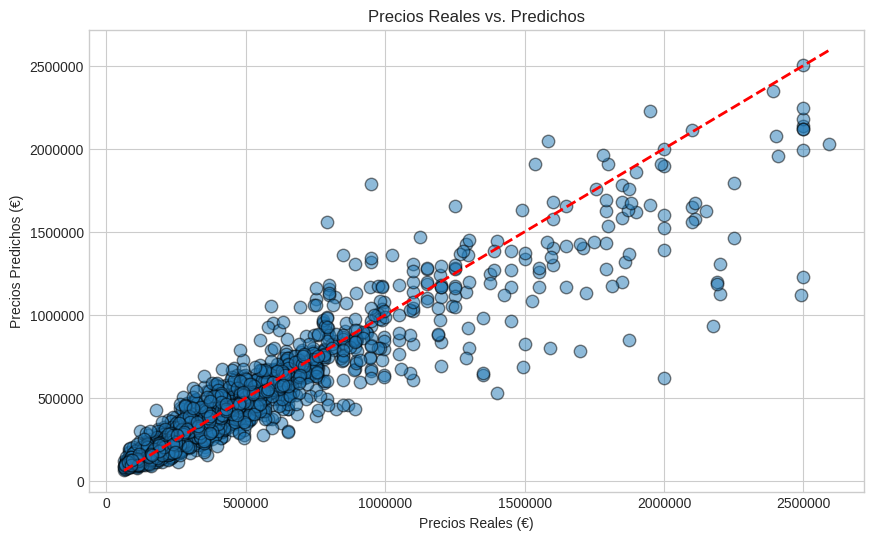

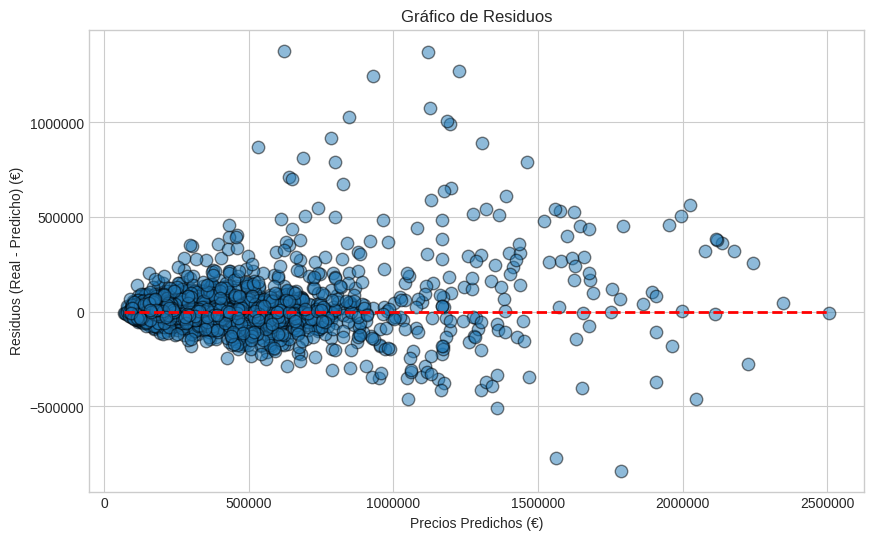

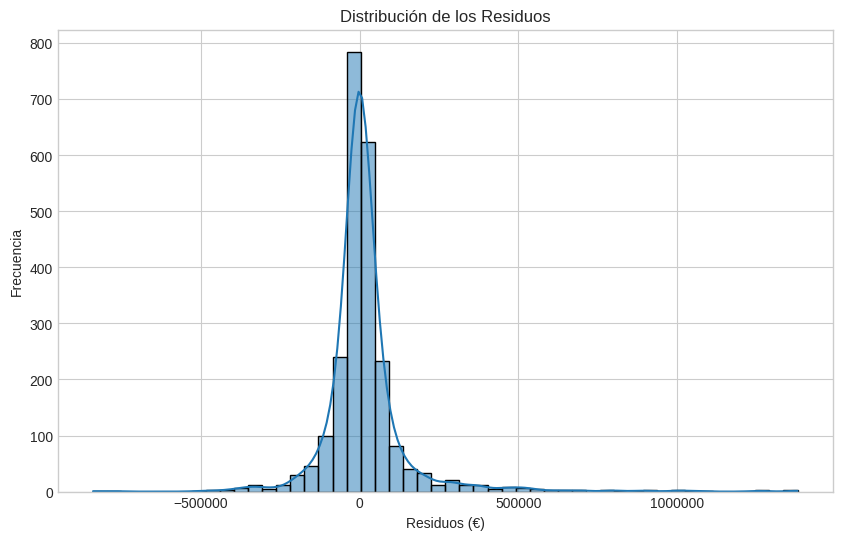

In [17]:
# BLOQUE 14: MÉTRICAS ADICIONALES Y GRÁFICOS DE RESIDUOS
# ---
# Continuamos usando y_test_orig y y_pred_orig de la escala original de precios.

# 1. Métricas Adicionales
medae = median_absolute_error(y_test_orig, y_pred_orig)
evs = explained_variance_score(y_test_orig, y_pred_orig)
max_err = max_error(y_test_orig, y_pred_orig)
mape = np.mean(np.abs((y_test_orig - y_pred_orig) / y_test_orig)) * 100 # Mean Absolute Percentage Error

print("--- Métricas Adicionales en Conjunto de Prueba (Escala Original) ---")
print(f"Median Absolute Error (MedAE): {medae:,.2f} €")
print(f"Explained Variance Score      : {evs:.4f}") # Mejor cerca de 1
print(f"Max Error                     : {max_err:,.2f} €") # El error más grande en una predicción
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print("\n")


# 2. Gráfico de Dispersión de Predicciones vs Reales
plt.figure(figsize=(10, 6))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.5, edgecolors='k', s=80)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--', lw=2)
plt.xlabel("Precios Reales (€)")
plt.ylabel("Precios Predichos (€)")
plt.title("Precios Reales vs. Predichos")
plt.ticklabel_format(style='plain', axis='both') # Evitar notación científica
plt.grid(True)
plt.show()

# 3. Gráfico de Residuos
# Los residuos son la diferencia entre los valores reales y los predichos.
residuos = y_test_orig - y_pred_orig

plt.figure(figsize=(10, 6))
plt.scatter(y_pred_orig, residuos, alpha=0.5, edgecolors='k', s=80)
plt.hlines(0, y_pred_orig.min(), y_pred_orig.max(), colors='r', linestyles='--', lw=2)
plt.xlabel("Precios Predichos (€)")
plt.ylabel("Residuos (Real - Predicho) (€)")
plt.title("Gráfico de Residuos")
plt.ticklabel_format(style='plain', axis='both')
plt.grid(True)
plt.show()

# Idealmente, los residuos deberían distribuirse aleatoriamente alrededor de la línea horizontal 0,
# sin patrones evidentes. Patrones pueden indicar problemas (ej. heterocedasticidad).

# 4. Histograma de Residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True, bins=50)
plt.xlabel("Residuos (€)")
plt.ylabel("Frecuencia")
plt.title("Distribución de los Residuos")
plt.ticklabel_format(style='plain', axis='x')
plt.grid(True)
plt.show()
# Idealmente, los residuos deberían seguir una distribución normal centrada en cero.

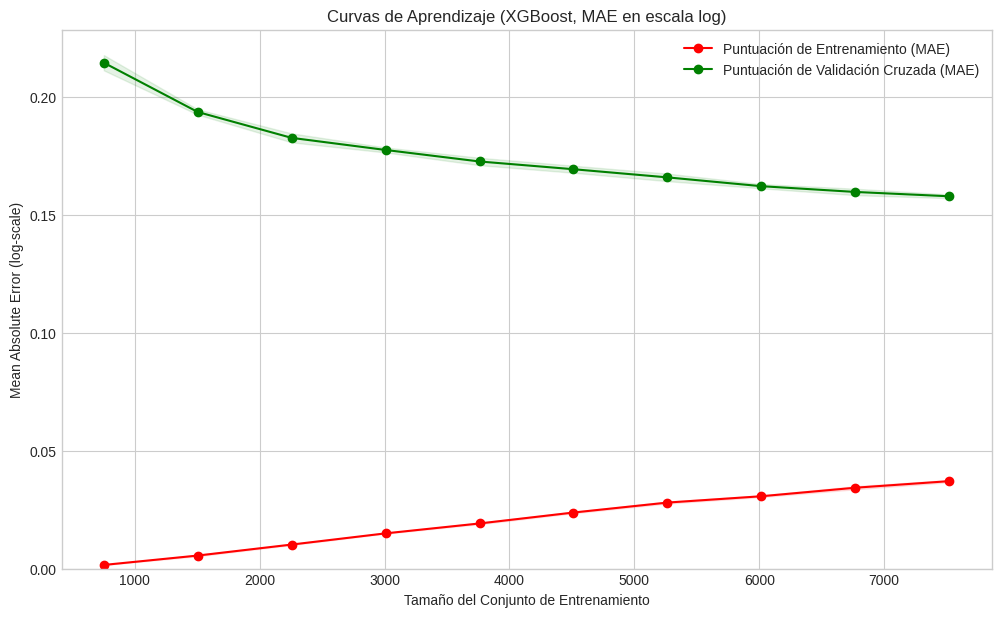

In [18]:
# BLOQUE 15: CURVAS DE APRENDIZAJE
# ---
# Las curvas de aprendizaje muestran cómo evoluciona el rendimiento del modelo
# (en entrenamiento y validación) a medida que aumenta el tamaño del conjunto de entrenamiento.
# Son útiles para diagnosticar si el modelo sufre de alto sesgo (underfitting)
# o alta varianza (overfitting), o si se beneficiaría de más datos.

# Usaremos el 'best_model' y los datos en la escala logarítmica (X_train, y_train)
# ya que el modelo fue entrenado así. La métrica debe ser una que scikit-learn pueda maximizar,
# por lo que si usamos MAE, será 'neg_mean_absolute_error'.

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=best_model, # Tu modelo XGBoost ya entrenado con los mejores hiperparámetros
    X=X_train, # Usar el conjunto de entrenamiento completo
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10), # Proporciones del dataset de entrenamiento a usar
    cv=5, # Número de folds para validación cruzada en cada tamaño
    scoring='neg_mean_absolute_error', # O 'r2', 'neg_mean_squared_error', etc.
    n_jobs=-1, # Usar todos los cores
    random_state=RNG # Para reproducibilidad
)

# Calcular la media y la desviación estándar de los scores
train_scores_mean = -train_scores.mean(axis=1) # Invertir signo para MAE
train_scores_std = train_scores.std(axis=1)
validation_scores_mean = -validation_scores.mean(axis=1) # Invertir signo para MAE
validation_scores_std = validation_scores.std(axis=1)

plt.figure(figsize=(12, 7))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                 validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Puntuación de Entrenamiento (MAE)")
plt.plot(train_sizes, validation_scores_mean, 'o-', color="g", label="Puntuación de Validación Cruzada (MAE)")

plt.title("Curvas de Aprendizaje (XGBoost, MAE en escala log)")
plt.xlabel("Tamaño del Conjunto de Entrenamiento")
plt.ylabel("Mean Absolute Error (log-scale)")
plt.legend(loc="best")
plt.grid(True)
plt.ylim(bottom=0) # MAE no puede ser negativo
plt.show()

# Interpretación de las curvas de aprendizaje:
# - Si ambas curvas convergen a un error alto: Alto sesgo (underfitting). El modelo es demasiado simple.
#   Soluciones: modelo más complejo, más características, ingeniería de características.
# - Si hay una gran brecha entre la curva de entrenamiento (error bajo) y la de validación (error alto):
#   Alta varianza (overfitting). El modelo memoriza el ruido de los datos de entrenamiento.
#   Soluciones: más datos, regularización, reducción de dimensionalidad, modelo más simple.
# - Si ambas curvas convergen a un error bajo y están cerca: El modelo generaliza bien.
# - Si la curva de validación sigue bajando y la de entrenamiento está estable:
#   El modelo podría beneficiarse de más datos.

In [19]:
# BLOQUE 16: CURVAS DE VALIDACIÓN (EJEMPLO CON UN HIPERPARÁMETRO)
# ---
# Las curvas de validación muestran cómo evoluciona el rendimiento del modelo
# al variar un único hiperparámetro. Ayuda a entender la sensibilidad del modelo
# a ese hiperparámetro y a elegir un buen valor si no se hizo una búsqueda exhaustiva.

# Vamos a variar 'max_depth' como ejemplo. Necesitas el estimador base sin este parámetro fijado.
# Asumimos que `rand_search.best_params_` tiene los otros mejores parámetros.
# Creamos un nuevo estimador XGBoost con esos parámetros, excepto el que vamos a variar.

best_params_for_validation_curve = rand_search.best_params_.copy()
# Eliminamos el parámetro que vamos a variar si estaba en best_params_
# param_name_to_vary = 'max_depth'
# if param_name_to_vary in best_params_for_validation_curve:
#     del best_params_for_validation_curve[param_name_to_vary]

# El modelo base ya está definido en rand_search.best_estimator_.
# Podemos usar ese estimador directamente.
estimator_for_validation = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=RNG,
    n_jobs=-1,
    tree_method='hist',
    **best_params_for_validation_curve # Usamos todos los mejores parámetros
)

# Rango de valores para 'max_depth'
param_range = [2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15]
param_name = 'max_depth' # Hiperparámetro de XGBoost a variar

train_scores_vc, validation_scores_vc = validation_curve(
    estimator_for_validation,
    X=X_train,
    y=y_train,
    param_name=param_name,
    param_range=param_range,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

# Calcular la media y la desviación estándar
train_scores_vc_mean = -train_scores_vc.mean(axis=1)
train_scores_vc_std = train_scores_vc.std(axis=1)
validation_scores_vc_mean = -validation_scores_vc.mean(axis=1)
validation_scores_vc_std = validation_scores_vc.std(axis=1)

plt.figure(figsize=(12, 7))
plt.title(f"Curva de Validación para '{param_name}' (XGBoost, MAE en escala log)")
plt.xlabel(f"Valor de '{param_name}'")
plt.ylabel("Mean Absolute Error (log-scale)")
plt.plot(param_range, train_scores_vc_mean, label="Puntuación de Entrenamiento", color="r", marker='o')
plt.fill_between(param_range, train_scores_vc_mean - train_scores_vc_std,
                 train_scores_vc_mean + train_scores_vc_std, alpha=0.1, color="r")
plt.plot(param_range, validation_scores_vc_mean, label="Puntuación de Validación Cruzada", color="g", marker='s')
plt.fill_between(param_range, validation_scores_vc_mean - validation_scores_vc_std,
                 validation_scores_vc_mean + validation_scores_vc_std, alpha=0.1, color="g")
plt.legend(loc="best")
plt.grid(True)
plt.ylim(bottom=0)
# plt.xticks(param_range) # Asegura que todos los valores del parámetro se muestren en el eje x
plt.show()

# Interpretación de las curvas de validación:
# - Si el error de entrenamiento es bajo y el de validación es alto y la brecha aumenta
#   con la complejidad del parámetro (ej. max_depth más alto): Overfitting.
# - Si ambos errores son altos: Underfitting.
# - Busca un punto donde el error de validación sea mínimo.
#   El valor óptimo del hiperparámetro suele estar donde la curva de validación alcanza su punto más bajo.

KeyboardInterrupt: 

In [ ]:
# BLOQUE 17: ANÁLISIS SHAP (OPCIONAL PERO MUY RECOMENDADO)
# ---
# SHAP (SHapley Additive exPlanations) es una técnica potente para explicar
# las predicciones de cualquier modelo de machine learning.
# Te dice cuánto contribuyó cada característica a una predicción particular
# o al comportamiento general del modelo.

# Necesitas instalarlo si no lo has hecho: !pip install shap

# Crear un explicador SHAP para modelos de árbol
explainer = shap.TreeExplainer(best_model, X_train) # Usamos X_train para el fondo, puede ser una muestra también.

# Calcular los valores SHAP para el conjunto de prueba (o una muestra de él para rapidez)
# Puede tardar un poco en datasets grandes.
num_samples_shap = min(1000, X_test.shape[0]) # Tomar una muestra para agilizar
X_test_sample_shap = X_test.sample(num_samples_shap, random_state=RNG) if X_test.shape[0] > num_samples_shap else X_test

shap_values = explainer.shap_values(X_test_sample_shap)
# Para XGBoost > 1.0, explainer(X_test_sample_shap) puede devolver un objeto Explainer con más info.
# Si shap_values es un objeto Explainer, puedes acceder a los valores con shap_values.values

# 1. Gráfico de Resumen SHAP (Importancia global y dirección del efecto)
print("--- Gráfico de Resumen SHAP ---")
shap.summary_plot(shap_values, X_test_sample_shap, plot_type="dot", show=False)
plt.title("Resumen SHAP: Impacto de las características en la predicción del log(precio)")
plt.show()
# Cada punto es un valor SHAP para una característica y una instancia.
# El color representa el valor de la característica (alto/bajo).
# La posición en el eje X indica el impacto en la predicción (positivo/negativo).

# 2. Gráfico de Importancia SHAP (similar a la importancia de características, pero más robusto)
print("\n--- Gráfico de Importancia SHAP (Media del valor SHAP absoluto) ---")
shap.summary_plot(shap_values, X_test_sample_shap, plot_type="bar", show=False)
plt.title("Importancia Media Absoluta SHAP")
plt.show()


# 3. Gráficos de Dependencia SHAP
# Muestran cómo cambia la predicción a medida que una característica cambia,
# y puede revelar interacciones con otra característica (coloreando los puntos por esa otra característica).
# Selecciona algunas características importantes para visualizar.
top_shap_features = pd.Series(np.abs(shap_values).mean(0), index=X_test_sample_shap.columns).sort_values(ascending=False).index

for feature_name in top_shap_features[:5]: # Visualiza para las 5 más importantes
    print(f"\n--- Gráfico de Dependencia SHAP para: {feature_name} ---")
    shap.dependence_plot(feature_name, shap_values, X_test_sample_shap, interaction_index="auto", show=False)
    # plt.title(f"Dependencia SHAP: {feature_name}") # shap.dependence_plot ya pone título
    plt.ylabel("Valor SHAP (Impacto en log(precio))")
    plt.show()

# 4. Explicación de una Predicción Individual (Waterfall plot)
# Elige una instancia específica del conjunto de prueba (ej. la primera)
instance_index = 0
shap_values_instance = explainer.shap_values(X_test.iloc[[instance_index]])
# Para xgboost > 1.0 y explainer()
# shap_values_instance_obj = explainer(X_test.iloc[[instance_index]])
# shap_values_instance = shap_values_instance_obj.values

# Los valores SHAP están en la escala logarítmica de la predicción.
# El valor base (explainer.expected_value) es la predicción media del modelo sobre el dataset de fondo.
print(f"\n--- Explicación SHAP para una instancia (Índice: {instance_index}) ---")
print(f"Valor base (predicción media log): {explainer.expected_value:.4f}")
print(f"Predicción del modelo para esta instancia (log): {best_model.predict(X_test.iloc[[instance_index]])[0]:.4f}")
print(f"Suma de valores SHAP + valor base: {shap_values_instance.sum() + explainer.expected_value:.4f}")


shap.waterfall_plot(shap.Explanation(
    values=shap_values_instance[0],
    base_values=explainer.expected_value,
    data=X_test.iloc[instance_index].values,
    feature_names=X_test.columns.tolist()
), show=False)
plt.title(f"Desglose SHAP para la predicción de la instancia {instance_index}")
plt.show()

# Si la instancia es y_test_orig.iloc[instance_index], el precio real es:
# print(f"Precio real original de la instancia {instance_index}: {np.expm1(y_test.iloc[instance_index]):,.2f} €")
# print(f"Precio predicho original de la instancia {instance_index}: {np.expm1(best_model.predict(X_test.iloc[[instance_index]])[0]):,.2f} €")

In [ ]:
# BLOQUE 11: Guardado del Pipeline Completo (CORREGIDO)
# ---
# Guarda todos los componentes necesarios (transformadores ajustados, modelo,
# metadatos, etc.) en un único archivo usando joblib para poder cargar
# y usar el pipeline completo para predicciones futuras sobre datos nuevos.

# 1. Definir Carpeta de Destino
#    - Especifica la ruta en Google Drive donde se guardará el archivo del pipeline.
#    - Crea la carpeta si no existe.
save_dir = '/content/drive/MyDrive/ModelosIdealista' # cite: 1
os.makedirs(save_dir, exist_ok=True) # cite: 1

# 2. Crear el Diccionario del Pipeline Completo
#    - Reúne todos los objetos ajustados y la información auxiliar necesaria
#      en un diccionario para serializarlo.
pipeline_completo = {
    # --- Objetos transformadores y modelo ajustados ---
    'scaler_geo': scaler_geo,               # Scaler para lat/lon (Bloque 4)
    'kmeans_geo': kmeans,                   # KMeans para clusters geo (Bloque 4)
    'pca_geo': pca_geo,                     # PCA para componente geo (Bloque 4)
    'target_encoder': te,                   # TargetEncoder (Bloque 5) # cite: 1
    'spline_transformer': spline,           # SplineTransformer (Bloque 6)
    'poly_features': poly,                  # PolynomialFeatures (Bloque 6)
    'scaler_final': scaler,                 # Scaler final para todas las numéricas (Bloque 8) # cite: 1
    'xgb_model': best_model,                # Modelo XGBoost entrenado (Bloque 9) # cite: 1

    # --- Información auxiliar y metadatos ---
    'pois': pois,                           # Dict de Puntos de Interés (Bloque 4)
    'floor_map': floor_map,                 # Mapeo para columna 'floor' (Bloque 3)
    'imputation_values': imputation_values, # Valores (medianas/modas) para imputar NaNs (Bloque 3)
    'cluster_avg_logprice_map': cluster_avg_logprice_map, # Mapeo cluster -> avg_price (Bloque 4)
    'spline_input_cols': spline_input_cols, # Columnas de entrada para SplineTransformer (Bloque 6)
    'poly_base_cols': num_base,             # Columnas base para PolynomialFeatures (Bloque 6) # cite: 1
    'te_cols': te_cols,                     # Columnas para TargetEncoder (Bloque 5) # cite: 1
    'scaled_num_cols': num_cols,            # Columnas escaladas por scaler_final (Bloque 8) # cite: 1
    'feature_order': feature_order          # Orden final de columnas para el modelo (Bloque 8) # cite: 1
}

# 3. Serializar (Guardar) el Pipeline Completo
#    - Define el nombre del archivo (usamos '_completo' para diferenciarlo del original).
file_save_path = os.path.join(save_dir, 'pipeline_idealista_completo.joblib')
#    - Usa joblib.dump para guardar el diccionario 'pipeline_completo' en el archivo especificado.
#      Joblib es eficiente para guardar objetos grandes como modelos de scikit-learn y arrays de numpy.
joblib.dump(pipeline_completo, file_save_path) # cite: 1 (modified)

# 4. Confirmación
print(f"\n✅ Pipeline COMPLETO exportado correctamente en: {file_save_path}")
print(f"   Componentes guardados: {list(pipeline_completo.keys())}")